# Urbansound8K Data Wrangling

The urban sound 8k dataset is a collection of annotated audio clips which can be used to develop applications for classifying sounds. It contains 8,732 labelled sound clips (4 seconds each) from ten classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gunshot, jackhammer, siren, and street music. The dataset by default is divided into 10-folds for cross validation. Merging the annotated chimpanzee clips with this dataset will allow us to build a classifier that can discriminatively classify chimpanzee sounds as well :)

The LibROSA package is central to the development of our model. It provides us with powerful tools for visualization, information retrieval and feature extraction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import librosa
from scipy.io import wavfile as wav
import IPython.display as ipd

In [2]:
data = pd.read_csv("D:/Thesis/UrbanSound8K/metadata/UrbanSound8K.csv")
data.shape

(8732, 8)

In [3]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The meta-data contains 8 columns:

- slice_file_name: name of the audio file
- fsID: FreesoundID of the recording where the excerpt is taken from
- start: start time of the clip
- end: end time of the clip
- salience: salience rating of the sound. 1 = foreground, 2 = background
- fold: The fold number (1–10) to which this file has been allocated
- classID:
    0 = air_conditioner
    1 = car_horn
    2 = children_playing
    3 = dog_bark
    4 = drilling
    5 = engine_idling
    6 = gun_shot
    7 = jackhammer
    8 = siren
    9 = street_music
- class: class name

The audio data has been already sliced and excerpted and even allocated to 10 different folds. Some of the excerpts are from the same original file but different slice. If one slice from a certain recording was in training data, and a different slice from the same recording was in test data, this might increase the accuracy of a final model falsely. Thanks to the original research, this has also been taken care of by allocating slices into folds such that all slices originating from the same Freesound recording go into the same fold.

Now let’s take a look at the class distribution of each fold to see how balanced the dataset is.

In [4]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,fold1,100,36,100,100,100,96,35,120,86,100
1,fold2,100,42,100,100,100,100,35,120,91,100
2,fold3,100,43,100,100,100,107,36,120,119,100
3,fold4,100,59,100,100,100,107,38,120,166,100
4,fold5,100,98,100,100,100,107,40,120,71,100
5,fold6,100,28,100,100,100,107,46,68,74,100
6,fold7,100,28,100,100,100,106,51,76,77,100
7,fold8,100,30,100,100,100,88,30,78,80,100
8,fold9,100,32,100,100,100,89,31,82,82,100
9,fold10,100,33,100,100,100,93,32,96,83,100


In [5]:
data['class'].value_counts(normalize=False)

air_conditioner     1000
engine_idling       1000
dog_bark            1000
drilling            1000
jackhammer          1000
street_music        1000
children_playing    1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

The dataset is relatively balanced with lesser frequencies of car_horn and gun_shot(s). Now, let us look at the other parameters to normalize: sampling rate, bit depth and number of channels.

In [6]:
from scipy.io import wavfile as wav
import IPython.display as ipd

def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('D:/Thesis/UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  car_horn


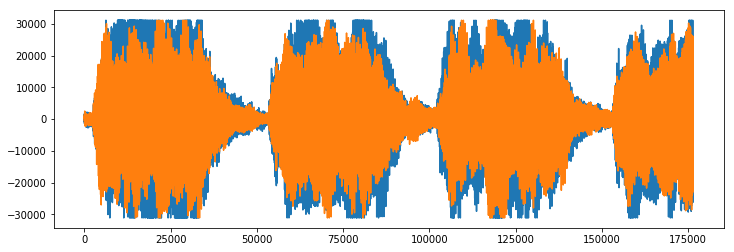

In [7]:
fullpath, label = path_class('9674-1-0-1.wav')
wav_plotter(fullpath,label)

In [8]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [9]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]

In [10]:
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,n_channels,sampling_rate,bit_depth
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,2,44100,16
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,2,44100,16
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,2,44100,16
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,2,44100,16
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,2,44100,16


In [11]:
data.sampling_rate.value_counts()

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sampling_rate, dtype: int64

In [12]:
data.n_channels.value_counts()

2    7993
1     739
Name: n_channels, dtype: int64

In [13]:
data.bit_depth.value_counts()

16    5758
24    2753
32     169
8       43
4        9
Name: bit_depth, dtype: int64

By default, Librosa will convert the sampling rate to 22.05khz, as well as reducing the number of channels to 1(mono), and normalize the data so that the values will range from -1 to 1. According to research, audio samples of 22.05kHz is sufficient for spectrogram analysis. 

In [14]:
data[data.slice_file_name == '22601-8-0-1.wav']

,slice_file_name,fsID,start,end,salience,fold,classID,class,n_channels,sampling_rate,bit_depth
5588,22601-8-0-1.wav,22601,0.5,4.5,2,3,8,siren,2,48000,16


In [15]:
fullpath,_ = path_class('22601-8-0-1.wav')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
scipy_sampling_rate, scipy_load = wav.read(fullpath)
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate)
print('\n')
print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))

original sample rate: 48000
converted sample rate: 22050


original wav file min~max range: -32767 ~ 32767
converted wav file min~max range: -0.52973473 ~ 0.5524689


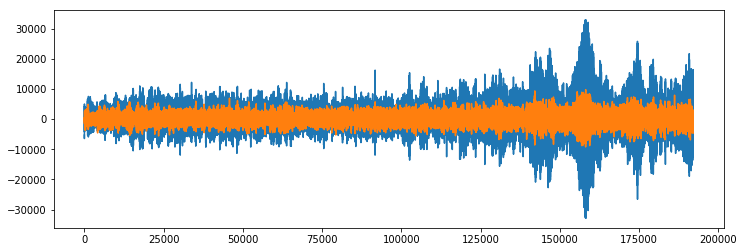

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_load)

In [17]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('D:/Thesis/UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def load_sound_files(file_paths):
    raw_sounds = []
    X,sr = librosa.load(file_paths)
    raw_sounds.append(X)
    return raw_sounds

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    #print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

def specshows(path_name,sound_names): 
    y, sr = librosa.load(path_name)
    plt.figure(figsize=(12, 8))    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.suptitle(sound_names)
    plt.title('Linear-frequency power spectrogram')
    
    plt.subplot(4, 2, 2)
    librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    
    CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr)), ref=np.max)
    plt.subplot(4, 2, 3)
    librosa.display.specshow(CQT, y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q power spectrogram (note)')    
    
    plt.subplot(4, 2, 4)
    librosa.display.specshow(CQT, y_axis='cqt_hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q power spectrogram (Hz)')
    
    C = librosa.feature.chroma_cqt(y=y, sr=sr)
    plt.subplot(4, 2, 5)
    librosa.display.specshow(C, y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    
    plt.subplot(4, 2, 6)
    librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear power spectrogram (grayscale)')
    
    plt.subplot(4, 2, 7)
    librosa.display.specshow(D, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log power spectrogram')
    
    plt.subplot(4, 2, 8)
    Tgram = librosa.feature.tempogram(y=y, sr=sr)
    librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
    plt.colorbar()
    plt.title('Tempogram')
    plt.tight_layout()

d:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


sampling rate:  44100 Hz
bit depth:  16
duration:  4.0  second
number of samples:  176400
class:  car_horn
sampling rate:  44100 Hz
bit depth:  16
duration:  4.0  second
number of samples:  176400
class:  children_playing
sampling rate:  44100 Hz
bit depth:  16
duration:  4.0  second
number of samples:  176400
class:  dog_bark
sampling rate:  48000 Hz
bit depth:  16
duration:  4.0  second
number of samples:  192000
class:  drilling
sampling rate:  11025 Hz
bit depth:  8
duration:  4.0  second
number of samples:  44100
class:  siren


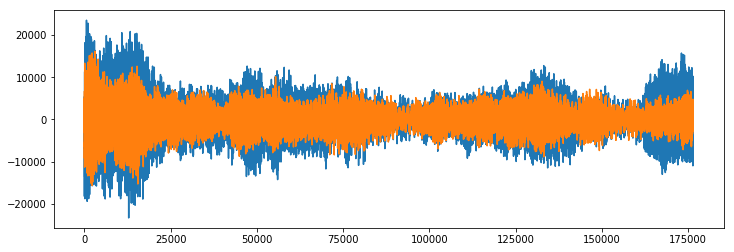

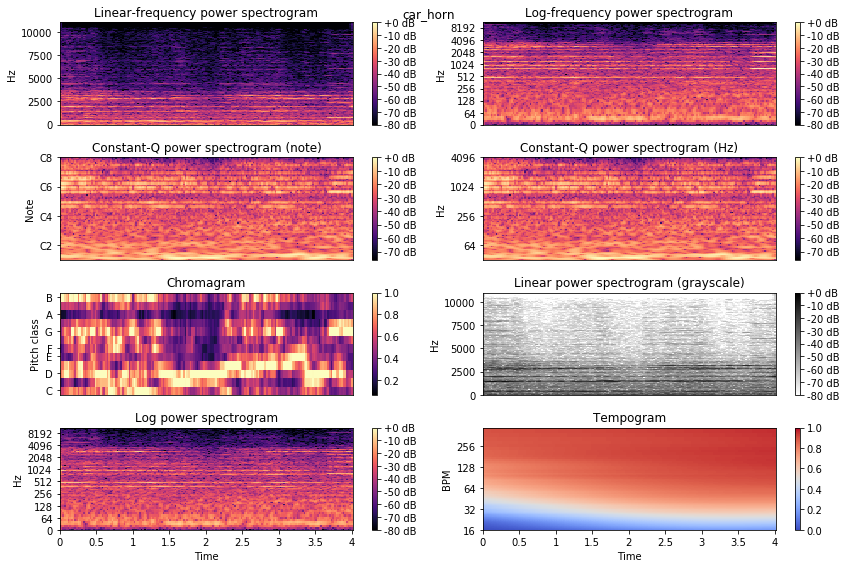

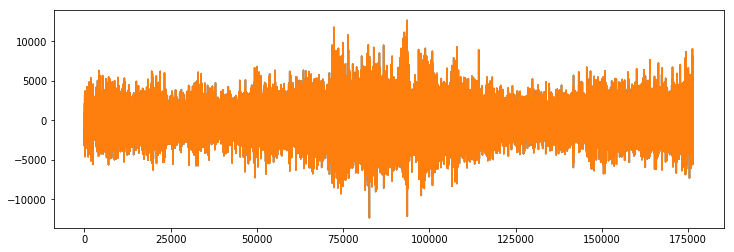

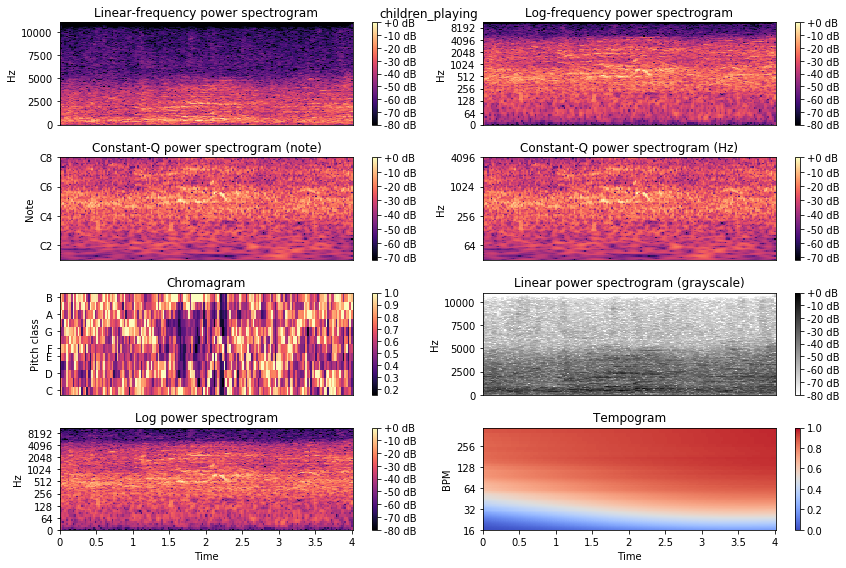

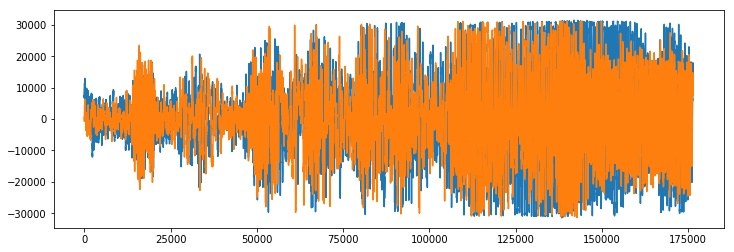

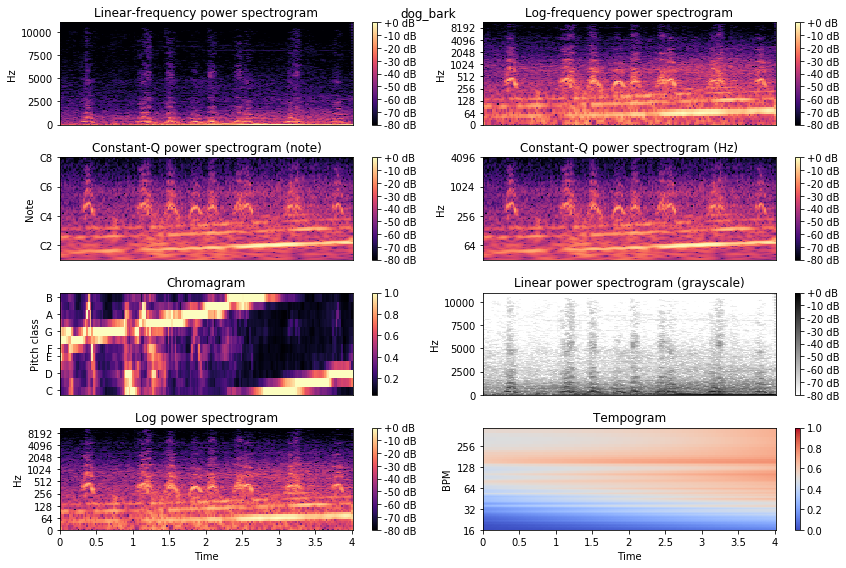

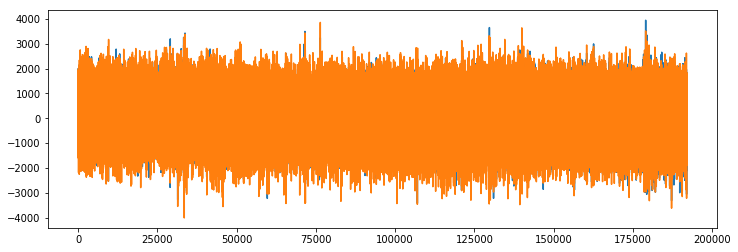

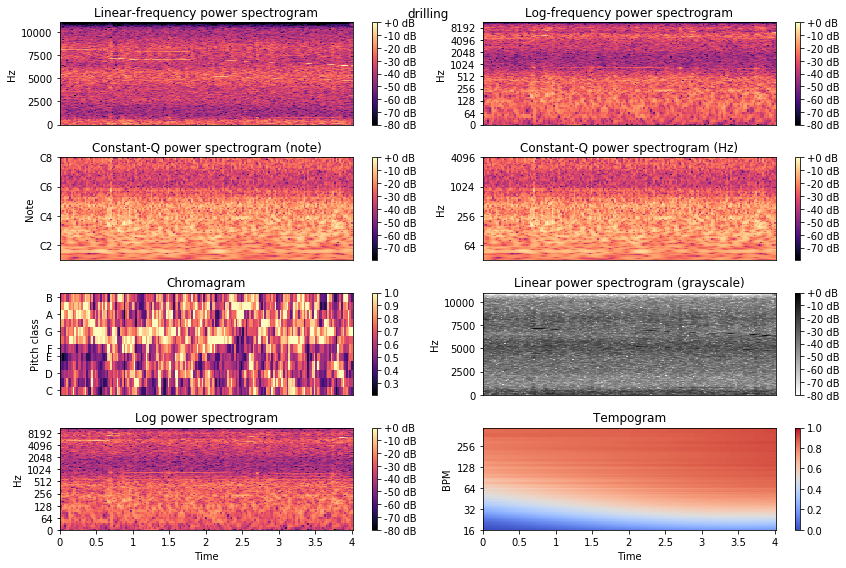

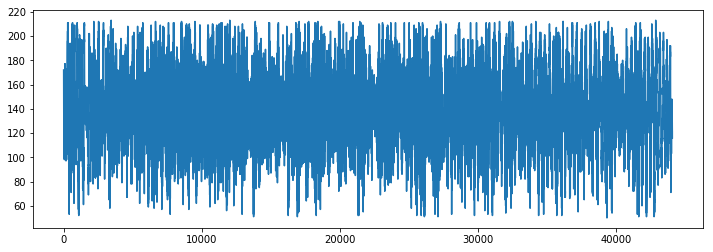

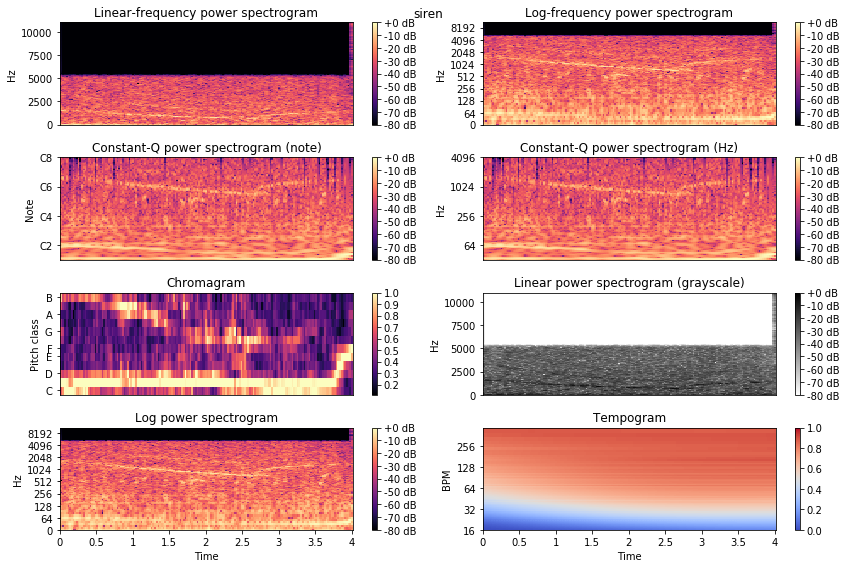

In [19]:
sound_file_paths = ["24074-1-0-3.wav","15564-2-0-1.wav","31323-3-0-1.wav",
"46669-4-0-35.wav","40722-8-0-4.wav",
"103074-7-3-2.wav","106905-8-0-0.wav","108041-9-0-4.wav" ]

#sound_file_paths = '57320-0-0-7.wav'
#sound_names = ["air conditioner","car horn","children playing",
#"dog bark","drilling","engine idling", "gun shot",
#"jackhammer","siren","street music"]
try:
    for i in range(len(sound_file_paths)):
        filepath, sound_name = path_class(sound_file_paths[i])
        raw_sounds = load_sound_files(filepath)
        wav_plotter(filepath,sound_name)
        specshows(filepath,sound_name)
except ValueError:
    pass

d:\python36\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


sampling rate:  22050 Hz
bit depth:  16
duration:  4.0  second
number of samples:  88200
class:  Chimps


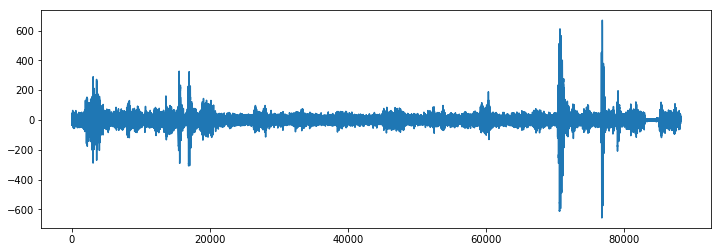

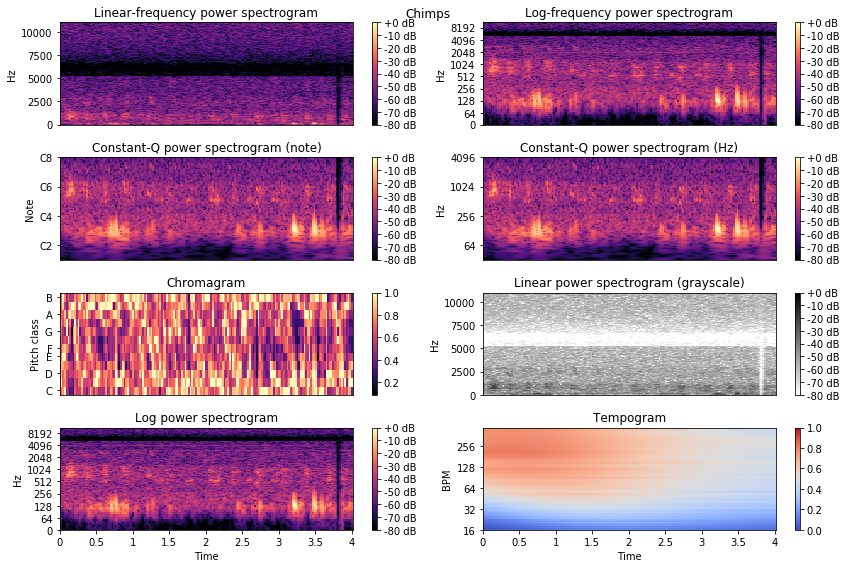

In [20]:
wav_plotter("D:/Thesis/UrbanSound8K/audio/fold1/Chimps-10-0 (73).wav", "Chimps")
specshows("D:/Thesis/UrbanSound8K/audio/fold1/Chimps-10-0 (73).wav", "Chimps")

Extracting features

In [30]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name, sr=22050, mono=True, offset=0.0, res_type='kaiser_fast')
    hop_length = 512
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
                print ("Error encountered while parsing file: ", fn)
                continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('\\')[5].split('-')[1])
            print(fn,fn.split('\\')[5].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)



In [22]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

### Normalize the data:
Sampling rate, bit depth, nchannels, 24-32 bit wav files, K-fold validation sets for chimp sets
Shuffled and arranged the chimp dataset into K folds accordingly

### Iteration1: Using a 3 layered NN with 1/5th of the total data

In [23]:
parent_dir = "D:\\Thesis\\UrbanSound8K\\audio"
tr_sub_dirs = ["fold1","fold2"]
ts_sub_dirs = ["fold3"]
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)
ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)


D:\Thesis\UrbanSound8K\audio\fold1\101415-3-0-2.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\101415-3-0-3.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\101415-3-0-8.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\102106-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\102305-6-0-0.wav 6
D:\Thesis\UrbanSound8K\audio\fold1\102842-3-0-1.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\102842-3-1-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\102842-3-1-5.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\102842-3-1-6.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-0-0.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-0-1.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-0-2.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-1-0.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-1-1.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-1-2.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-1-3.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-1-4.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\103074-7-1-5.wav 7
D:\Thesis\UrbanSound8K\audio

D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-21.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-22.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-23.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-24.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-25.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-26.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-27.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-28.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-4.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-5.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-6.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-7.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-8.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\134717-0-0-9.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\135776-2-0-32.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\135776-2-0-37.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\135776-2-0-40.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\135776-2-0-49.wav 2
D:\Thesis\UrbanS

D:\Thesis\UrbanSound8K\audio\fold1\159738-8-0-4.wav 8
D:\Thesis\UrbanSound8K\audio\fold1\159738-8-0-5.wav 8
D:\Thesis\UrbanSound8K\audio\fold1\159738-8-0-6.wav 8
D:\Thesis\UrbanSound8K\audio\fold1\159738-8-0-7.wav 8
D:\Thesis\UrbanSound8K\audio\fold1\159738-8-0-8.wav 8
D:\Thesis\UrbanSound8K\audio\fold1\159738-8-0-9.wav 8
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-1.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-11.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-22.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-30.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-31.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-47.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-5.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160009-2-0-50.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\160094-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\161702-9-0-26.wav 9
D:\Thesis\UrbanSound8K\audio\fold1\161702-9-0-30.wav 9
D:\Thesis\UrbanSound8K\audio\fold1\161702-9-0-37.wav 9
D:\Thesis\UrbanSoun

d:\python36\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


D:\Thesis\UrbanSound8K\audio\fold1\17592-5-1-1.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\17592-5-1-2.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\17592-5-1-3.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\176257-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\176258-3-1-12.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\176258-3-1-13.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\176258-3-1-18.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\176258-3-1-2.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\176638-1-0-0.wav 1
D:\Thesis\UrbanSound8K\audio\fold1\176638-1-1-0.wav 1
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-18.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-23.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-26.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-33.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-40.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-51.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-55.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\176714-2-0-77.wav 2
D:\Thesis\UrbanSound

D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-10.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-11.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-12.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-13.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-14.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-2.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-3.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-4.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-5.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-6.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-7.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-8.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\180937-7-4-9.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\182800-2-0-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\182800-2-1-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\182800-2-2-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\182800-2-2-1.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\182800-2-2-2.wav 2
D:\Thesis\UrbanSound8K\

D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-33.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-35.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-36.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-37.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-39.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-4.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-45.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-48.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-49.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-54.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-61.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-63.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-8.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46669-4-0-9.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\46918-5-0-0.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\46918-5-0-1.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\46918-5-0-2.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\50901-0-0-0.wav 0
D:\Thesis\UrbanSound8K\audio\fold1\

d:\python36\lib\site-packages\librosa\util\utils.py:1467: RuntimeWarning: invalid value encountered in less
  if np.any(X < 0) or np.any(X_ref < 0):
d:\python36\lib\site-packages\librosa\util\utils.py:1479: RuntimeWarning: invalid value encountered in maximum
  Z = np.maximum(X, X_ref).astype(dtype)
d:\python36\lib\site-packages\librosa\util\utils.py:1480: RuntimeWarning: invalid value encountered in less
  bad_idx = (Z < np.finfo(dtype).tiny)


D:\Thesis\UrbanSound8K\audio\fold1\87275-1-5-0.wav 1
D:\Thesis\UrbanSound8K\audio\fold1\88466-7-0-0.wav 7
D:\Thesis\UrbanSound8K\audio\fold1\89212-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\89948-5-0-0.wav 5
D:\Thesis\UrbanSound8K\audio\fold1\9031-3-1-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\9031-3-2-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\9031-3-3-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\9031-3-4-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold1\94868-1-0-0.wav 1
D:\Thesis\UrbanSound8K\audio\fold1\94868-1-1-0.wav 1
D:\Thesis\UrbanSound8K\audio\fold1\94868-1-2-0.wav 1
D:\Thesis\UrbanSound8K\audio\fold1\96158-4-0-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0-22.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0-23.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0-25.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0-28.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0-34.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0-36.wav 2
D:\Thesis\UrbanSound8K\audio\fold1\97317-2-0

D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-1.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-10.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-11.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-12.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-13.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-14.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-15.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-2.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-3.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-4.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-5.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-6.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-7.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-8.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\102871-8-0-9.wav 8
D:\Thesis\UrbanSound8K\audio\fold2\104817-4-0-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\104817-4-0-1.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\104817-4-0-10.wav 4
D:\Thesis\UrbanSound8

D:\Thesis\UrbanSound8K\audio\fold2\146690-0-0-86.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\146690-0-0-87.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\146690-0-0-93.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147672-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\147672-3-1-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\147672-3-2-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\14780-9-0-0.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\14780-9-0-1.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\14780-9-0-2.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-10.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-11.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-12.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-16.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-17.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-2.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-20.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-21.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\147926-0-0-27.wav 0
D:\Thesis\UrbanSound

D:\Thesis\UrbanSound8K\audio\fold2\168713-9-0-32.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\168713-9-0-33.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\168713-9-0-38.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\168713-9-0-46.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\168713-9-0-62.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\168713-9-0-82.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-0.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-1.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-2.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-3.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-4.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-5.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-6.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-7.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-8.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-0-9.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-1-0.wav 7
D:\Thesis\UrbanSound8K\audio\fold2\169098-7-2-0.wav 7
D:\Thesis\UrbanSound8K

D:\Thesis\UrbanSound8K\audio\fold2\192269-2-0-35.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\192269-2-0-37.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\192269-2-0-54.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\192269-2-0-56.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\194841-9-0-130.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\194841-9-0-144.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\194841-9-0-164.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\194841-9-0-178.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\194841-9-0-222.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\194841-9-0-48.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\196063-2-0-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\196063-2-0-1.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\196063-2-0-2.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\196067-2-0-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\196078-2-0-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\196082-2-0-0.wav 2
D:\Thesis\UrbanSound8K\audio\fold2\196384-9-0-11.wav 9
D:\Thesis\UrbanSound8K\audio\fold2\196384-9-0-15.wav 9
D:\Thesis\U

D:\Thesis\UrbanSound8K\audio\fold2\23131-3-2-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\23131-3-4-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\23131-3-5-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\27349-3-0-2.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\27349-3-0-6.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\27349-3-1-2.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\27349-3-2-1.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\33849-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\33849-3-2-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\33849-3-3-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\33849-3-4-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-0-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-1-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-11-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-12-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-13-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-14-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-4-15-0.wav 4
D:\Thesis\UrbanSound8K\audio\fold2\34621-

D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-15.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-16.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-17.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-18.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-2.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-20.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-22.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-23.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-24.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-25.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-27.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-28.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-3.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-4.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-5.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-6.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-8.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\74507-0-0-9.wav 0
D:\Thesis\UrbanSound8K\audio\fold2\

D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (130).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (131).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (132).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (133).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (134).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (135).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (136).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (137).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (138).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (139).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (140).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (141).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (142).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (143).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (144).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimps-10-0 (145).wav 10
D:\Thesis\UrbanSound8K\audio\fold2\Chimp

D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-1.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-10.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-11.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-12.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-13.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-14.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-16.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-17.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-18.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-19.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-20.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-22.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-23.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-24.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-25.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-26.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-27.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\13230-0-0-28.wav 0
D:\Thesis\UrbanSound8K\audio\

D:\Thesis\UrbanSound8K\audio\fold3\156418-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\156418-3-0-1.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\156418-3-1-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\156418-3-2-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-0.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-1.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-2.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-3.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-4.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-5.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-6.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-7.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\159761-0-0-8.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\160093-3-0-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\161195-6-0-0.wav 6
D:\Thesis\UrbanSound8K\audio\fold3\162431-6-0-0.wav 6
D:\Thesis\UrbanSound8K\audio\fold3\162431-6-1-0.wav 6
D:\Thesis\UrbanSound8K\audio\fold3\162431-6-2-0.wav 6
D:\Thesis\UrbanSound8K\audio

D:\Thesis\UrbanSound8K\audio\fold3\182103-9-0-47.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\182103-9-0-53.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\182103-9-0-8.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\184623-8-0-0.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\184623-8-0-1.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\184623-8-0-2.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\184623-8-0-3.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\184623-8-1-0.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\184725-3-0-1.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\184725-3-0-2.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\184725-3-0-4.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\184725-3-0-5.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\185373-9-0-21.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\185373-9-0-6.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\185373-9-1-17.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\185373-9-1-46.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\185373-9-1-7.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\185373-9-1-70.wav 9
D:\Thesis\UrbanSound8K

D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-28.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-29.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-3.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-30.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-31.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-32.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-33.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-34.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-35.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-36.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-37.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-38.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-39.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-4.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-40.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-41.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-42.wav 8
D:\Thesis\UrbanSound8K\audio\fold3\22601-8-0-43.wav 8
D:\Thesis\UrbanSound8K\audio\f

D:\Thesis\UrbanSound8K\audio\fold3\58806-0-0-0.wav 0
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-10.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-12.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-13.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-14.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-16.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-25.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-7.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\58857-2-0-8.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\61791-9-1-1.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\61791-9-1-40.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\61791-9-1-41.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\61791-9-1-42.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\61791-9-1-44.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\61791-9-1-46.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\62837-7-0-12.wav 7
D:\Thesis\UrbanSound8K\audio\fold3\62837-7-0-15.wav 7
D:\Thesis\UrbanSound8K\audio\fold3\62837-7-0-16.wav 7
D:\Thesis\UrbanSound8K\audio\fol

D:\Thesis\UrbanSound8K\audio\fold3\76221-2-0-6.wav 2
D:\Thesis\UrbanSound8K\audio\fold3\77769-9-0-0.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\77769-9-0-12.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\77769-9-0-17.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\77769-9-0-2.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\77769-9-0-4.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\77769-9-0-8.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78326-9-0-0.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78326-9-0-1.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78326-9-0-3.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78326-9-0-5.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78326-9-0-6.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78326-9-0-7.wav 9
D:\Thesis\UrbanSound8K\audio\fold3\78776-6-0-0.wav 6
D:\Thesis\UrbanSound8K\audio\fold3\82811-3-0-1.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\82811-3-0-2.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\82811-3-3-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\82811-3-4-0.wav 3
D:\Thesis\UrbanSound8K\audio\fold3\88569-2-0

D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (259).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (260).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (261).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (262).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (263).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (264).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (265).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (266).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (267).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (268).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (269).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (270).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (271).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (272).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (273).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimps-10-0 (274).wav 10
D:\Thesis\UrbanSound8K\audio\fold3\Chimp

In [117]:
tr_labels = one_hot_encode(tr_labels)
ts_labels = one_hot_encode(ts_labels)

In [47]:
#tr_features.shape
file_name="D:/Thesis/UrbanSound8K/audio/fold1/Chimps-10-0 (73).wav"
X, sample_rate = librosa.load(file_name, sr=22050, mono=True, offset=0.0, res_type='kaiser_fast')
stft = np.abs(librosa.stft(X))
mfcc = librosa.feature.mfcc(y= X, sr = sample_rate, n_mfcc=40, hop_length = 512)
chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate, hop_length =512)
#X.shape
print(chroma.shape)
print(mfcc.shape)
chroma

(12, 173)
(40, 173)


array([[0.5822883 , 0.66369269, 0.76172343, ..., 1.        , 0.83399363,
        0.79699866],
       [0.60393439, 0.7023617 , 0.7578386 , ..., 0.78862853, 0.88897518,
        0.85643708],
       [0.65042494, 0.82324778, 0.9224805 , ..., 0.914676  , 0.98078047,
        0.91171469],
       ...,
       [0.72983002, 0.70094067, 0.74216107, ..., 0.67728276, 0.67393237,
        0.68247304],
       [0.4352309 , 0.53915723, 0.76510883, ..., 0.76799883, 0.75141032,
        0.73932242],
       [0.39085823, 0.56466597, 0.81414397, ..., 0.95179139, 0.76641224,
        0.784317  ]])

Tensorflow Version 1

In [118]:
training_epochs = 50
n_dim = tr_features.shape[1]
n_classes = 11
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [ ]:
tr_features.shape[1]

In [120]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [128]:
cost_function = tf.reduce_mean(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print("Test accuracy: ",round(sess.run(accuracy, 
    	feed_dict={X: ts_features,Y: ts_labels}),3))

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
print("F-Score:", round(f,3))